<a href="https://colab.research.google.com/github/paulodowd/GoogleColab_Simple2DSimulator/blob/main/Sheet2_SimpleSensorModel_ResponseCurve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In the simulation we have explored, the proximity sensors returned an exact distance to an obstacle.  In reality, sensors do not work perfectly.  A more accurate, precise and reliable a sensor will often cost more money.  

If we are going to use a simulator to develop control solutions for robotics, then it is important that the simulator models the real performance of hardware as best as possible.  If the simulation does not model reality well, then our control solution is unlikely to work well when we transfer it from simulation to the real robot.  

In robotics, this issue of how well a simulated solution transfers to a real robot is called the **reality gap**, and continues to be an active area of research.

In this exercise sheet we will look at a low cost proximity sensor. We will use this sensor to understand some of the steps we might take to improve how well a simulation represents reality.  

# The Simulated Sensor Response

Our 2D Simulation uses a very simple model of a sensor.  If we take a closer look at the `ProxSensor_c` class, we see the following code storing **distance** as the **sensor reading**:

```python
    ...

    # If the current reading is -1 then that means
    # this is the first valid reading, and we update
    # the sensor.
    if self.reading < 0:
      self.reading = distance

    # If the sensor already has a valid reading (>-1)
    # then we only store the new reading if it is closer.
    # (closer obstructions block the field of view)
    if self.reading > 0:
      if distance < self.reading:
        self.reading = distance

    ...
```

We can also find within the `ProxSensor_c` class the following line of code, where the <a href="https://en.wikipedia.org/wiki/Euclidean_distance#:~:text=In%20mathematics%2C%20the%20Euclidean%20distance,being%20called%20the%20Pythagorean%20distance.">euclidean distance</a> from the robot to the obstruction is calculated:

```python
    # See if the obstruction is within the detection
    # range of the sensor.
    distance = np.sqrt( ((obstruction.x - self.x)**2) + ((obstruction.y - self.y)**2) )
```

This means that our simulated sensor reading is the exact distance between the sensor and the obstruction.  If we were to produce a graph of the way the simulated sensor currently responds, it would look like:



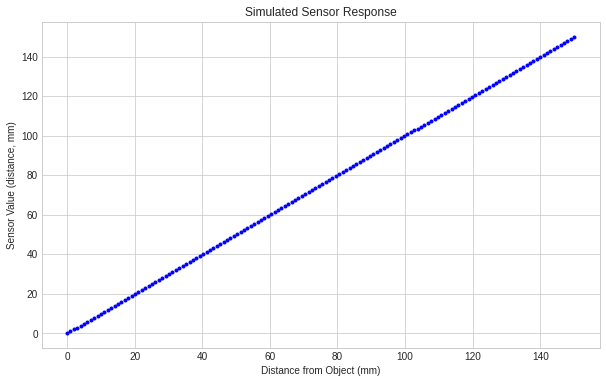

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

# Create an x axis with 150 distance points
x = np.linspace( 0, 150, 150 )

# Create a y axis, which has an exact (1:1) correspondence
# with distance (this is how our simulation currently works)
y = np.linspace( 0, 150, 150 )

plt.figure(figsize=(10,6))
plt.title("Simulated Sensor Response")
plt.xlabel('Distance from Object (mm)')
plt.ylabel('Sensor Value (distance, mm)')
plt.plot(x,y,'.', color='blue')


In reality, sensors rarely work this way or this well.  


# The Pololu SDS02A Response

<p align="center">
<img src="https://a.pololu-files.com/picture/0J5782.600x480.jpg?d0dc29ca33bde495d7507411e2fa3a8d" width="25%">
</p>

We are going to construct a simple model of the Pololu SDS02A Sensor pictured above (<a href="https://www.pololu.com/product/2476">product page</a>).  

We can view the official datasheet (<a href="https://www.pololu.com/file/0J812/gp2y0a60szxf_e.pdf">here</a>) for this sensor and find the following graph.  This graph shows how the voltage of the sensor varies with respect to it's distance to an object:

<p align="center">
<img src="https://previews.dropbox.com/p/thumb/ABKZpeQj3uUM_evAg-4y5ANToFREYswQ99VoxXkT10294pNteswL2uFJ_NjgCIVaqXhYPHbQ9aYa7gCpiQeHpCY-rh79EEHgX-j3N10vvZ-YnxdP70k4VMr6aubM1vDgvvLv2skhq2zfKnhYyskIcHQ9G60_-Tl06JaBd2isK3onFYSA5bNHyk-l4IiFelkNvqur95oIkzoUwjRIxPruj0bNmeHL_34XWRTOlvjrhNgjCHpbqnwMifgGezMA4mRLogFZpiNwtR5r9VUyzuytZJzKIl-TNqieJycLWVkdpfiTwVx8eWgalDafD9EokiNBhhsJVjLmtnSjtsbXCt-Xve0yr11r_Q7Q8LTGtqtTEEgPnA/p.png?fv_content=true&size_mode=5" width="75%">
</p>

First of all, **this looks very different to our current simulated response!**

We can read the above graph as:
 > "sensor output voltage decreases non-linearly with respect to an increasing distance" 

Some things to immediately notice are that:
- the sensor output is a voltage, not a unit of distance. 
- the response is not linear, meaning the amount the voltage varies with respect to distance is not constant.
- the data has been captured against white paper, which means we should expect it to vary against other surfaces and conditions.
- the graph doesn't tell us what happens at values less than 10cm, or greater than 150cm.



When we find information like this inside datasheets, it is important to test our own hardware to see how it performs within our own robotic system.  

Poly fit co-efficients: [ 2.15860810e+02  3.08818528e+01 -4.90831337e-01  3.07397197e-03
 -8.70724210e-06  9.22678754e-09]


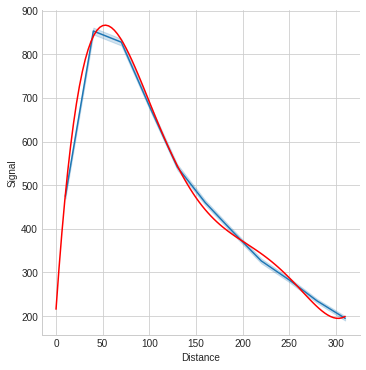

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
Data=pd.read_csv('https://raw.githubusercontent.com/paulodowd/GoogleColab_Simple2DSimulator/main/prox_data.csv')

# Preview first 10 entries:
#Data.head(10)

sns.relplot(x="Distance", y="Signal", kind="line", ci="sd", data=Data);

import numpy.polynomial.polynomial as poly

#print( Data.loc[:, 'Distance'] )
x = Data.loc[:, 'Distance']
y = Data.loc[:, 'Signal']
coefs = poly.polyfit(x, y, 5)

# https://stackoverflow.com/questions/18767523/fitting-data-with-numpy
# In general: np.polynomial.polynomial.polyfit returns coefficients [A, B, C] to A + Bx + Cx^2 + ...
# print the co-efficients where:
# g(x) = A + Bx + Cx^2 + Dx^3 + Ex^4 + Fx^5
# This might be useful :)
# https://www.calculatorsoup.com/calculators/math/scientific-notation-converter.php
#
# Print out the co-efficients of the poly fit curve
print( "Poly fit co-efficients:", coefs )

# create a higher resolution of x-series points to process
# the polynomial fit.
x_new = np.linspace( 0, max( Data.loc[:,'Distance']), 100 )

# We can manually generate the points of the poly fit
# curve using 
# g(x) = A + Bx + Cx^2 + Dx^3 + Ex^4 + Fx^5
#
# y_new = []
# for i in range( len( x_new ) ):
#   y_new.append( 215.860810 + 
#               ( 30.8818528 * x_new[i]) + 
#               (-0.490831337 * (x_new[i]**2) ) +
#               (0.00307397197 * (x_new[i]**3) ) +
#               (-0.00000870724210 * (x_new[i]**4) ) +
#               (0.00000000922678754 * (x_new[i]**5) ) )
#
# plt.plot(x_new, y_new, c="orange")

ffit = poly.polyval(x_new, coefs)
plt.plot(x_new, ffit, c="red")



